# Milestone Project 2: SkimLit 📰🔥

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they use to achieve their best results os available here: https://arxiv.org/abs/1612.05251

## Get data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [1]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [2]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + "/" + f for f in os.listdir(data_dir)]
filenames

['PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to...

> Visualize, visualize, visualize

So with that in mid, let's write a function to read in all of the lines of a target text file.

In [3]:
# Create function to read the lines of a document
def get_lines(filename):
    """
    Reads filename (a text file) and returns the lines of text as a list.
    Args:
        filename: a string containing the target filepath.

    Returns:
        a list of strings with one string per line from the target file.
    """
    with open(filename, "r") as file:
        return file.readlines()

In [4]:
# Let's read in the training lines
train_lines = get_lines(data_dir + "/train.txt")
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Let's think about how we want our data to look...

How i think our data would be best represented...

```
[{  'line_number': 0,
    'target': 'BACKGROUND',
    'text': 'Emotional eating is associated with overeating and the development of obesity .\n',
    'total_lines': 11},
    ...]
```

In [5]:
# Create a function to split the lines of data into a list of dictionaries
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionaries of abstract line data.

    Args:
        filename: a string containing the target filepath.

    Returns:
        a list of dictionaries each containing the keys, 'line_number', 'target', 'text', and 'total_lines'.
    """
    input_lines = get_lines(filename) # get all lines from filename
    abstract_lines = "" # create an empty abstract
    abstract_samples = [] # create an empty list to hold abstracts

    # Loop through each line in target file
    for line in input_lines:
        if line.startswith("###"): # check to see if the line is an ID line
            abstract_id = line
            abstract_lines = "" # reset the abstract string if the line is an ID line
        elif line.isspace(): # check to see if the line is a new line
            abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines
            total_lines = len(abstract_line_split) - 1 # get the total number of lines in the current abstract

            # Iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # create an empty dictionary for each line
                target_text_split = abstract_line.split("\t") # split target label from text
                line_data["target"] = target_text_split[0] # get target label
                line_data["text"] = target_text_split[1].lower() # get target text and lower it
                line_data["line_number"] = abstract_line_number # what line does the line appear in the abstract?
                line_data["total_lines"] = total_lines # add the total number of lines in the abstract
                abstract_samples.append(line_data) # add line data to abstract samples list

        else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
            abstract_lines += line

    return abstract_samples

In [6]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "/train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "/dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "/test.txt")

# Check the first abstract of the training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it.

In [7]:
# Turn data into pandas dataframe
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [8]:
# Distribution of labels in the training data
train_df["target"].value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

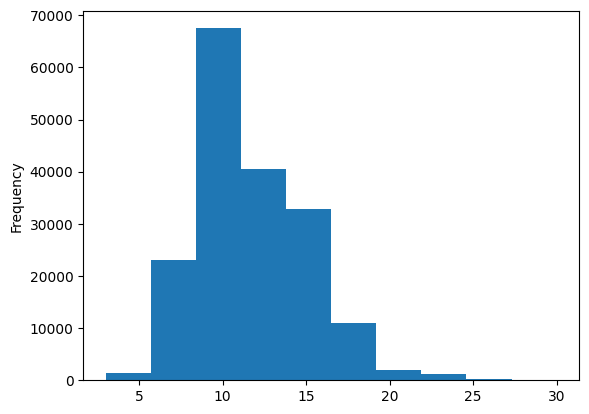

In [9]:
# Let's check the length of different abstracts
train_df.total_lines.plot.hist()

### Get lists of sentences

In [10]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

## Make numeric labels (ML models require numeric labels)

In [11]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder

# Create one-hot encoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1)) # reshape to a 2D array
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1)) # don't fit the validation or test labels
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1)) # don't fit the validation or test labels

# Check the shape of the one-hot encoded labels
train_labels_one_hot.shape, val_labels_one_hot.shape, test_labels_one_hot.shape

((180040, 5), (30212, 5), (30135, 5))

### Encode labels

In [12]:
# Extract labels from one-hot encoded labels
from sklearn.preprocessing import LabelEncoder

# Create a label encoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check the first 5 samples of the encoded training labels
train_labels_encoded[:5]

array([3, 2, 2, 2, 2])

In [13]:
# Get the class names of the dataset
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments...

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline (TF-ID Multinomial Naive Bayes classifier).

## Model 0: Baseline model

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),  # convert words to numbers using tfidf
    ("clf", MultinomialNB())  # model the text
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [15]:
# Evaluate the baseline model on the validation dataset
baseline_score = model_0.score(val_sentences, val_labels_encoded)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 72.18%


### Add helper functions 

In [16]:
import sys
from contextlib import contextmanager

# Define a context manager to temporarily add a path to sys.path
@contextmanager
def temporary_sys_path_append(path):
    sys.path.append(path)  # Add the specified path to sys.path
    try:
        yield  # Allow code within the with-block to execute
    finally:
        # Ensure the path is removed after exiting the with-block
        sys.path.remove(path)

# Using the context manager to temporarily add a path to sys.path
with temporary_sys_path_append('..'):
    # Inside this block, you can import modules located in the added path
    from helper_functions import calculate_results
    # Use the function or perform actions with the imported module here

# Outside the with-block, the path is no longer in sys.path, limiting the change to the block

2024-08-25 14:45:30.218768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 14:45:30.384734: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 14:45:30.430227: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-25 14:45:30.759528: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-25 14:45:32.166267: W tensorflow/compiler/tf2

In [17]:
# Calculate baseline results
baseline_preds = model_0.predict(val_sentences)
baseline_results = calculate_results(y_true=val_labels_encoded, y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 71.86466952323352,
 'recall': 72.1832384482987,
 'f1': 69.89250353450294}

## Model ME1: Conv1D with tokens Embedding

In [18]:
# Find the average number of tokens in the training data
max_length_me = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))
max_length_me

26

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization # type: ignore

# Setup text vectorization variables
max_vocab_length_me = 10000 # max number of words to have in our vocabulary

text_vectorizer_me = TextVectorization(max_tokens=max_vocab_length_me,
                                    output_mode="int",
                                    output_sequence_length=max_length_me,
                                    pad_to_max_tokens=True)

I0000 00:00:1724607934.117308    1492 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:29:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724607934.529327    1492 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:29:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724607934.529404    1492 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:29:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724607934.532827    1492 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:29:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724607934.532880    1492 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:29:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [20]:
# Fit the text vectorizer to the training text
text_vectorizer_me.adapt(train_sentences)

# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer_me([sample_sentence])

<tf.Tensor: shape=(1, 26), dtype=int64, numpy=
array([[1, 8, 1, 5, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0]])>

In [21]:
# Choose a random sentence from the training dataset and tokenize it
import random

random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\n\nVectorized version:")
text_vectorizer_me([random_sentence])

Original text:
clinical measures included a plaque index , gingival index , gingival bleeding time index , probing depth , and clinical attachment level .

Vectorized version:


<tf.Tensor: shape=(1, 26), dtype=int64, numpy=
array([[  47,  213,  121,    8, 1072,  203, 2377,  203, 2377,  506,   63,
         203, 4145, 1920,    3,   47, 5304,  204,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [22]:
from tensorflow.keras import layers # type: ignore

embedding_me = layers.Embedding(input_dim=max_vocab_length_me,  # set input shape
                             output_dim=128,  # output shape
                             embeddings_initializer="uniform")  # default, initialize randomly

In [23]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\n\nEmbedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding_me(text_vectorizer_me([random_sentence]))
sample_embed

Original text:
we noted significant decreases in the total ipss scores ( p = @ ) , irritative subscore ( p = @ ) , qol ( p = @ ) , flank pain ( p = @ ) , voiding pain ( p = @ ) and amount of analgesics used ( p = @ ) in the groups .

Embedded version:


<tf.Tensor: shape=(1, 26, 128), dtype=float32, numpy=
array([[[-0.00883741,  0.02801399,  0.0269395 , ..., -0.02272172,
          0.02968049,  0.02274558],
        [-0.02665566, -0.02008665, -0.04979985, ..., -0.01272167,
         -0.03859073, -0.04439948],
        [ 0.02670063, -0.00978918, -0.01157165, ..., -0.02629209,
          0.01404169, -0.00645436],
        ...,
        [-0.04661689,  0.01651749, -0.0093734 , ..., -0.00091083,
         -0.03525377, -0.02555132],
        [-0.00737578,  0.04645046,  0.0453417 , ...,  0.02234639,
         -0.00641521, -0.04395962],
        [-0.01748442,  0.0428667 ,  0.03682685, ..., -0.00093759,
          0.03020686,  0.0488573 ]]], dtype=float32)>

In [24]:
# Create a tensorboard callback (need to create a new one for each model)
SAVE_DIR = "model_logs"

In [25]:
# 1D Convolutional Neural Network (CNN) for text
from tensorflow.keras import layers # type: ignore

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer_me(inputs)
x = embedding_me(x)
x = layers.Conv1D(filters=64, kernel_size=5, padding="same", activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1_me = tf.keras.Model(inputs, outputs, name="model_1_conv1D")

# Model summary
model_1_me.summary()

Model: "model_1_conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 26)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 26, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 26, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,321,349 (5.04 MB)

 Trainable params: 1,321,349 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers. 

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers # type: ignore

In [27]:
# How long is each sentences on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

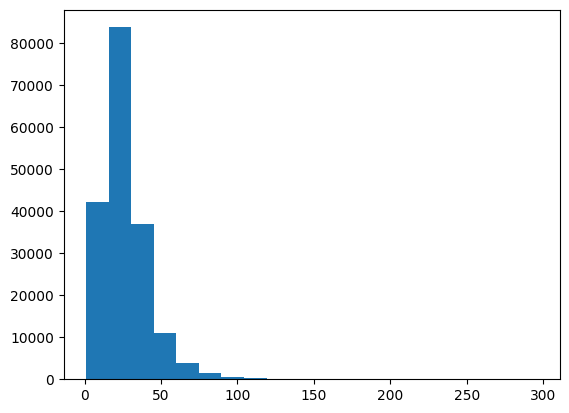

In [28]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)

In [29]:
# How long of a sentence length covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [30]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

In [31]:
# How many words are in the vocabulary?
max_vocab_length = 68000

In [32]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization # type: ignore

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_sequence_length=output_seq_len)

In [33]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [34]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}\n\nLength of text: {len(target_sentence.split())}\n\nVectorized text:{text_vectorizer([target_sentence])}")

Text:
content validity of pictograms was first confirmed by @ fd patients .

Length of text: 12

Vectorized text:[[ 1014  1984     4 14610    10   152   736    22  3447    12     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [35]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [36]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

In [37]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), 
                               output_dim=128, 
                               mask_zero=True, 
                               name="token_embedding")

In [38]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
content validity of pictograms was first confirmed by @ fd patients .

Sentence after vectorization (before embedding):
[[ 1014  1984     4 14610    10   152   736    22  3447    12     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[-0.04726857  0.02078556  0.01228225 ...  0.03561396 -0.01056226
   -0.03147714]
  [-0.01543901 -0.010844   -0.03157254 ...  0.03879866 -0.04609797
    0.04268951]
  [ 0.01445368  0.01109297  0.00162908 ...  0.00108516  0.03069801
    0.03136159]
  ...
  [-0.00108944 -0.03374715 -0.04764761 ...  0.02481438 -0.04785013
   -0.01898781]
  [-0.00108944 -0.03374715 -0.04764761 ...  0.02481438 -0.04785013
   -0.01898781]
  [-0.00108944 -0.03374715 -0.04764761 ...  0.02481438 -0.0

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [39]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [40]:
# Take the TensorFlow Datasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [41]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of the model
model_1.summary()

/home/gus/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_embedding (Embedding)     │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 55, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3


2024-08-25 14:45:41.201525: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8904
W0000 00:00:1724607941.710699    1873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607941.772383    1873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607941.793085    1873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607941.803936    1873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607941.812501    1873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607941.825028    1873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607941.833917    1873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607941.841931    1873 gpu_t

  5/562 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.3955 - loss: 1.5944 

W0000 00:00:1724607942.712956    1873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607942.714853    1873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607942.716334    1873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607942.717658    1873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607942.718806    1873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607942.721181    1873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607942.723254    1873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607942.724292    1873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607942.727589    1873 gp

560/562 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5254 - loss: 1.1680

W0000 00:00:1724607952.379208    1876 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607952.381116    1876 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607952.382626    1876 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607952.384132    1876 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607952.385842    1876 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607952.387357    1876 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607952.388858    1876 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607952.390429    1876 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607952.392046    1876 gp

562/562 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.5260 - loss: 1.1667 - val_accuracy: 0.7364 - val_loss: 0.7004
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7428 - loss: 0.6899 - val_accuracy: 0.7630 - val_loss: 0.6414
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7693 - loss: 0.6280 - val_accuracy: 0.7889 - val_loss: 0.5972


In [43]:
# Evaluate the model
model_1.evaluate(valid_dataset)

  1/945 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.5312 - loss: 0.8778

943/945 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7848 - loss: 0.6018

W0000 00:00:1724607981.339945    1871 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607981.356411    1871 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607981.378449    1871 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607981.383989    1871 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607981.389697    1871 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607981.404491    1871 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607981.411956    1871 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607981.423821    1871 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607981.438936    1871 gp

945/945 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7848 - loss: 0.6018


W0000 00:00:1724607981.544248    1871 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607981.554735    1871 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607981.558053    1871 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607981.569216    1871 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607981.572574    1871 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607981.586426    1871 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607981.599543    1871 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607981.601213    1871 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724607981.602606    1871 gp

[0.603701114654541, 0.7845227122306824]

In [44]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs[0], model_1_pred_probs[0].argmax(), class_names[model_1_pred_probs[0].argmax()]

945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


(array([0.42749396, 0.15027013, 0.0908569 , 0.29895252, 0.03242644],
       dtype=float32),
 0,
 'BACKGROUND')

In [45]:
# Convert prediction probabilities to class labels
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [46]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.45227062094531,
 'precision': 78.13443536764174,
 'recall': 78.45227062094531,
 'f1': 78.23220819628571}

## Model 2: Feature extraction with pretrained token embeddings

Now lets use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder:https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder

In [47]:
# Fixing keras 3.x.x bug
import tf_keras as keras

In [48]:
# Download pretrained TensorFlow Hub Universal Sentence Encoder
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [49]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n{random_train_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
at the end of each hour , the work of breathing ( assessed by measuring the diaphragmatic pressure time product ) , thoracoabdominal asynchrony and respiratory muscle strength ( maximal inspiratory pressure , maximal expiratory pressure ( pemax ) and maximal transdiaphragmatic pressure ( pdimax ) ) were assessed .

Sentence after embedding:
[ 0.00372005 -0.03095101 -0.06370953  0.05215947  0.03718262 -0.02673784
  0.0675349  -0.06035817  0.04561601  0.06375203  0.03725459  0.07617384
  0.00492155 -0.02329854  0.05919176 -0.04453888  0.03818089  0.05967914
 -0.05537584  0.00890966 -0.00305576 -0.01216595 -0.0615646   0.03993133
 -0.02335846  0.02771994 -0.06719897 -0.03310617 -0.07499836 -0.06159964] (truncated output)...

Length of sentence embedding: 512


### Building and fitting an NLP feature extraction model using pretrained embeddings TensorFlow Hub

In [50]:
# Define feature extraction model using Tf Hub layer

inputs = keras.layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = keras.layers.Dense(128, activation="relu")(pretrained_embedding)
# Note: you could add more layers here if you wanted to
outputs = keras.layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = keras.Model(inputs=inputs, outputs=outputs, name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

# Model summary
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [51]:
# Fit the model_2 to the data
model_2_history = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3


I0000 00:00:1724608034.471861    1875 service.cc:146] XLA service 0x7ff0f0004c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724608034.471900    1875 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-08-25 14:47:14.495322: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1724608034.634194    1875 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


562/562 [==============================] - 21s 34ms/step - loss: 0.9132 - accuracy: 0.6493 - val_loss: 0.7954 - val_accuracy: 0.6878
Epoch 2/3
562/562 [==============================] - 19s 34ms/step - loss: 0.7692 - accuracy: 0.7006 - val_loss: 0.7549 - val_accuracy: 0.7028
Epoch 3/3
562/562 [==============================] - 20s 35ms/step - loss: 0.7543 - accuracy: 0.7106 - val_loss: 0.7414 - val_accuracy: 0.7091


In [52]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 28s 30ms/step - loss: 0.7436 - accuracy: 0.7126


[0.743576169013977, 0.7125645279884338]

In [53]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs[:10]

945/945 [==============================] - 21s 22ms/step


array([[4.3403301e-01, 3.7032709e-01, 2.4470580e-03, 1.8400972e-01,
        9.1831516e-03],
       [3.3519536e-01, 5.1659316e-01, 3.5612897e-03, 1.4140452e-01,
        3.2456606e-03],
       [2.3528054e-01, 1.2967992e-01, 1.6610671e-02, 5.8050388e-01,
        3.7924964e-02],
       [1.1945140e-02, 4.9218729e-02, 8.1201768e-01, 6.7365188e-03,
        1.2008193e-01],
       [2.9980341e-02, 2.2733976e-01, 2.1428470e-01, 1.2931581e-02,
        5.1546359e-01],
       [9.3365385e-04, 2.1673476e-03, 6.9077814e-01, 9.0721776e-05,
        3.0603009e-01],
       [1.8611875e-03, 3.5859307e-03, 6.9459873e-01, 1.1150960e-03,
        2.9883909e-01],
       [3.5370034e-03, 2.3679212e-02, 4.7871590e-01, 9.8101737e-04,
        4.9308693e-01],
       [6.2409200e-04, 7.5762565e-03, 2.1756260e-02, 9.6991658e-04,
        9.6907347e-01],
       [1.3188629e-01, 7.0806992e-01, 2.5312465e-02, 6.5220647e-02,
        6.9510669e-02]], dtype=float32)

In [54]:
# Convert the prediction probabilities found with feature extraction model to class labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 1, 3, 2, 4, 2, 2, 4, 4, 1])>

In [55]:
# Calculate model_2 results
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.25645438898451,
 'precision': 71.29492199225227,
 'recall': 71.25645438898451,
 'f1': 70.97888106033653}

## Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.

Previously we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

### Creating a character-level tokenizer

In [56]:
# Make function to split sentences into characters
def split_chars(text):
    return " ".join(list(text))

# Text splitting non-character level sequences into characters
split_chars(random_train_sentence)

'a t   t h e   e n d   o f   e a c h   h o u r   ,   t h e   w o r k   o f   b r e a t h i n g   (   a s s e s s e d   b y   m e a s u r i n g   t h e   d i a p h r a g m a t i c   p r e s s u r e   t i m e   p r o d u c t   )   ,   t h o r a c o a b d o m i n a l   a s y n c h r o n y   a n d   r e s p i r a t o r y   m u s c l e   s t r e n g t h   (   m a x i m a l   i n s p i r a t o r y   p r e s s u r e   ,   m a x i m a l   e x p i r a t o r y   p r e s s u r e   (   p e m a x   )   a n d   m a x i m a l   t r a n s d i a p h r a g m a t i c   p r e s s u r e   (   p d i m a x   )   )   w e r e   a s s e s s e d   .'

In [57]:
# Split sequence-level data into character-level data
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

# Check the first 5 sequences after being split into characters
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [58]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

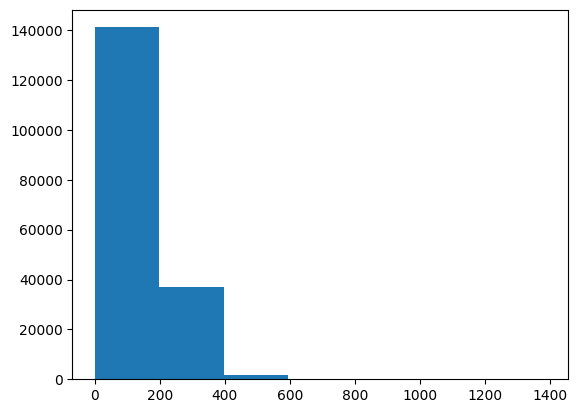

In [59]:
# Check the distribution of our character lengths
plt.hist(char_lens, bins=7)

In [60]:
# Find the character length which covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [61]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [62]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

In [63]:
# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [64]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [65]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}\n")
print(f"Length of random_train_chars: {len(random_train_chars.split())}\n")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized chars:\n{vectorized_chars}\n")
print(f"Length of vectorized chars:\n{len(vectorized_chars[0])}")

Charified text:
t h e   s t u d y   i s   r e g i s t e r e d   w i t h   c l i n i c a l t r i a l s . g o v   ,   s t u d y   i d   n c t @   .

Length of random_train_chars: 55

Vectorized chars:
[[ 3 13  2  9  3 16 10 19  4  9  8  2 18  4  9  3  2  8  2 10 20  4  3 13
  11 12  4  6  4 11  5 12  3  8  4  5 12  9 18  7 21  9  3 16 10 19  4 10
   6 11  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

### Creating a character-level embedding

In [66]:
# Create a character-level embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=True, # use masking to handle variable sequence lengths
                              name="char_embed")

In [67]:
# Test our character embedding layer
print(f"Charified text:\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
t h e   s t u d y   i s   r e g i s t e r e d   w i t h   c l i n i c a l t r i a l s . g o v   ,   s t u d y   i d   n c t @   .

Embedded chars (after vectorization and embedding):
[[[ 0.01815966  0.04300502 -0.03872709 ... -0.0460179   0.0116148
    0.00363271]
  [-0.03543181 -0.00404597  0.00037615 ... -0.03270443  0.02815555
   -0.01906381]
  [ 0.03460943 -0.00295057 -0.04650177 ... -0.03061271  0.01747483
    0.04335699]
  ...
  [-0.02461052  0.01745626 -0.03011566 ...  0.01630216  0.0249163
    0.04060984]
  [-0.02461052  0.01745626 -0.03011566 ...  0.01630216  0.0249163
    0.04060984]
  [-0.02461052  0.01745626 -0.03011566 ...  0.01630216  0.0249163
    0.04060984]]]

Character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [68]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv1D_char_embedding")

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

/home/gus/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [69]:
# Get a summary of the model
model_3.summary()

Model: "model_3_conv1D_char_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_vectorizer                 │ (None, 290)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_embed (Embedding)          │ (None, 290, 25)        │           700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 290, 64)        │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
# Create char-level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [71]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3


W0000 00:00:1724608147.922699    1875 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608147.926860    1875 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608147.930750    1875 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608147.935366    1875 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608147.938790    1875 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608147.943247    1875 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608147.946619    1875 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608147.951317    1875 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608147.955889    1875 gp

  1/562 ━━━━━━━━━━━━━━━━━━━━ 12:07 1s/step - accuracy: 0.0938 - loss: 1.6358

W0000 00:00:1724608148.126517    1873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608148.131832    1873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608148.136971    1873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608148.140574    1873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608148.145464    1873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608148.150830    1873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608148.153529    1873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608148.154825    1873 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608148.156192    1873 gp

560/562 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4278 - loss: 1.3822

W0000 00:00:1724608157.370575    1867 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608157.425705    1867 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608157.430056    1867 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608157.433548    1867 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608157.437190    1867 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608157.440673    1867 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608157.444331    1867 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608157.447837    1867 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608157.452332    1867 gp

562/562 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.4282 - loss: 1.3814 - val_accuracy: 0.5761 - val_loss: 1.0484
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.5867 - loss: 1.0357 - val_accuracy: 0.6313 - val_loss: 0.9416
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.6317 - loss: 0.9381 - val_accuracy: 0.6579 - val_loss: 0.8881


In [72]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)

# Calculate model_3 results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


W0000 00:00:1724608183.063867    1875 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608183.069075    1875 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608183.072235    1875 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608183.078621    1875 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608183.083019    1875 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608183.086030    1875 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608183.089449    1875 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608183.092376    1875 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724608183.096558    1875 gp

{'accuracy': 65.83145769892758,
 'precision': 64.86093082874962,
 'recall': 65.83145769892758,
 'f1': 64.67845165898865}

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 and 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [73]:
# Fix keras bug for char model
# Create char-level token vectorizer instance
alphabet = list("abcdefghijklmnopqrstuvwxyz")  # Ejemplo de alfabeto
char_vocab = list("abcdefghijklmnopqrstuvwxyz") + [" ", "OOV"]  # Ejemplo de vocabulario con espacio y OOV

# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2  
char_vectorizer = keras.layers.TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_sequence_length=output_seq_char_len,
    standardize="lower_and_strip_punctuation",
    name="char_vectorizer"
)
char_vectorizer.adapt(char_vocab)  

# Create a character-level embedding layer
char_embed = keras.layers.Embedding(
    input_dim=len(char_vocab),  
    output_dim=25,  
    mask_zero=True,  
    name="char_embed"
)

In [74]:
# 1. Setup token inputs/model
token_inputs = keras.layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = keras.layers.Dense(128, activation="relu")(token_embeddings)
token_model = keras.Model(inputs=token_inputs,
                          outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = keras.layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_vectors = tf.cast(char_vectors, tf.int32)  # Convertir explícitamente a int32 si es necesario
char_embeddings = char_embed(char_vectors)
char_bi_lstm = keras.layers.Bidirectional(keras.layers.LSTM(24))(char_embeddings) # bi-LSTM for sequence modelling
char_model = keras.Model(inputs=char_inputs,
                        outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = keras.layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

# 4. Create output layers - add in dropout
combined_dropout = keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = keras.layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = keras.layers.Dropout(0.5)(combined_dense)
output_layer = keras.layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = keras.Model(inputs=[token_model.input, char_model.input],
                     outputs=output_layer,
                     name="model_4_token_and_char_embeddings")

# Get a summary of the model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 tf.cast (TFOpLambda)        (None, 290)                  0       

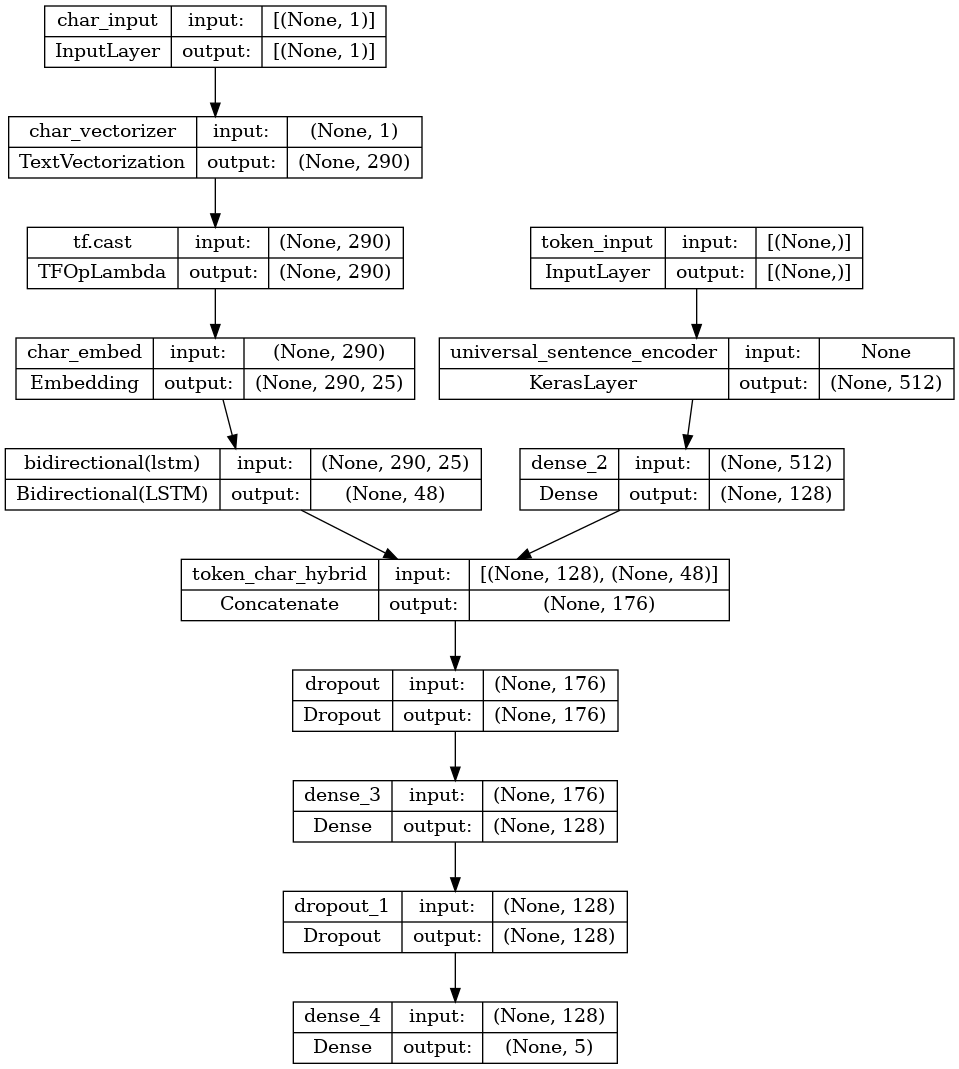

In [75]:
# Plot hybrid token and character model
keras.utils.plot_model(model_4, show_shapes=True, show_layer_names=True)

In [76]:
# Compile the model
model_4.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token and character data into a tf.data Dataset

In [77]:
# Combine token and char datasets
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

# Check out the training char and token dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

> It is crucial to maintain the same order of inputs in the model definition and in the preparation of the combined dataset to ensure that the data is processed correctly.

### Fitting a model on token and character-level sequences

In [78]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3


2024-08-25 14:49:51.392936: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_36/output/_23'


562/562 [==============================] - 66s 105ms/step - loss: 0.9929 - accuracy: 0.6039 - val_loss: 0.7878 - val_accuracy: 0.7001
Epoch 2/3
562/562 [==============================] - 57s 101ms/step - loss: 0.8008 - accuracy: 0.6898 - val_loss: 0.7170 - val_accuracy: 0.7234
Epoch 3/3
562/562 [==============================] - 50s 89ms/step - loss: 0.7741 - accuracy: 0.7050 - val_loss: 0.6926 - val_accuracy: 0.7394


In [79]:
# Evaluate the model on the validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 46s 48ms/step - loss: 0.6938 - accuracy: 0.7357


[0.6937729716300964, 0.7356679439544678]

In [80]:
# Make predictions using the token-character model
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)

# Calculate model_4 results
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

945/945 [==============================] - 44s 45ms/step


{'accuracy': 73.566794651132,
 'precision': 73.62905053800182,
 'recall': 73.566794651132,
 'f1': 73.29392100790614}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

> 🔑**Note:** Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

### Create positional embeddings

In [81]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

line_number
0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

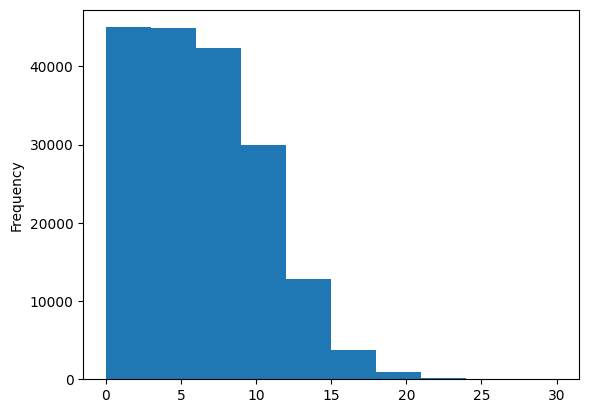

In [82]:
# Check the distribution of line numbers
train_df["line_number"].plot.hist()

In [83]:
# Use TensorFlow to create one-hot-encoded tensors of the line_number column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

Otra manera de hacerlo

Agrupar valores mayores o iguales a 15

train_df["line_number_grouped"] = train_df["line_number"].apply(lambda x: x if x < 15 else 15)

One-hot encoding con un depth de 16 (15 + 1)

train_line_numbers_one_hot = tf.one_hot(train_df["line_number_grouped"].to_numpy(), depth=16)

In [84]:
# How many different total lines are there?
train_df["total_lines"].value_counts().sort_values()

total_lines
27       28
30       31
3        32
28       58
26       81
25      182
24      200
4       215
23      264
22      759
21      770
5      1146
20     1281
19     2480
18     3344
6      3353
17     5202
16     7429
7      7464
15    10768
8     12285
14    14610
13    18438
9     19400
12    22113
10    23639
11    24468
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

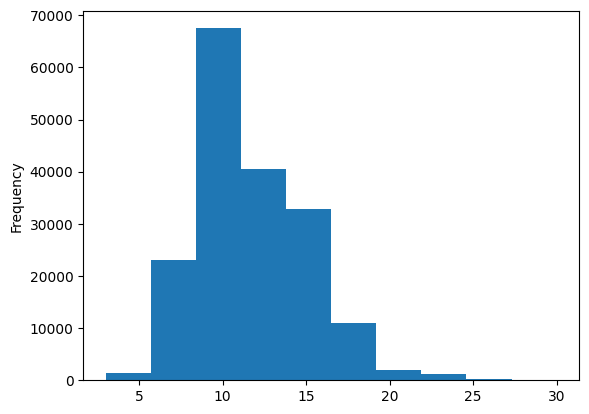

In [85]:
# Check the distribution of total lines
train_df["total_lines"].plot.hist()

In [86]:
# Use TensorFlow to create one-hot-encoded tensors of the total_lines column
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

### Building a hybrid embedding model

1. Create a token-level model
2. Create a character-level-model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 and 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3,4,5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the embeddings and output label probabilities
8. Combine the inputs of 1,2,3,4 and outputs of into a tf.keras.Model

In [87]:
# 1. Token inputs
token_inputs = keras.layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = keras.layers.Dense(128, activation="relu")(token_embeddings)
token_model = keras.Model(inputs=token_inputs,
                          outputs=token_outputs)

# 2. Char inputs
char_inputs = keras.layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_vectors = tf.cast(char_vectors, tf.int32)  # Ensure inputs are int (needed for embedding layer)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = keras.layers.Bidirectional(keras.layers.LSTM(24))(char_embeddings)
char_model = keras.Model(inputs=char_inputs,
                        outputs=char_bi_lstm)

# 3. Line number inputs
line_number_inputs = keras.layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
x = keras.layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = keras.Model(inputs=line_number_inputs,
                                outputs=x)

# 4. Total lines inputs
total_lines_inputs = keras.layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = keras.layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = keras.Model(inputs=total_lines_inputs,
                                outputs=y)

# 5. Combine token and char models with line number inputs
combined_embeddings = keras.layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])
z = keras.layers.Dense(256, activation="relu")(combined_embeddings)
z = keras.layers.Dropout(0.5)(z)  # add dropout for regularization
z = keras.layers.Dense(128, activation="relu")(z)

# 6. Combine positional embeddings with combined embeddings
tribrid_embeddings = keras.layers.Concatenate(name="token_char_positional_hybrid")([line_number_model.output,
                                                                                     total_lines_model.output,
                                                                                     z])

# 7. Create output layer
output_layer = keras.layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model
model_5 = keras.Model(inputs=[token_model.input, char_model.input, line_number_model.input, total_lines_model.input],
                     outputs=output_layer,
                     name="model_5_tribrid_model")

# Get a summary of the model
model_5.summary()

Model: "model_5_tribrid_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 tf.cast_1 (TFOpLambda)      (None, 290)                  0         ['char_vec

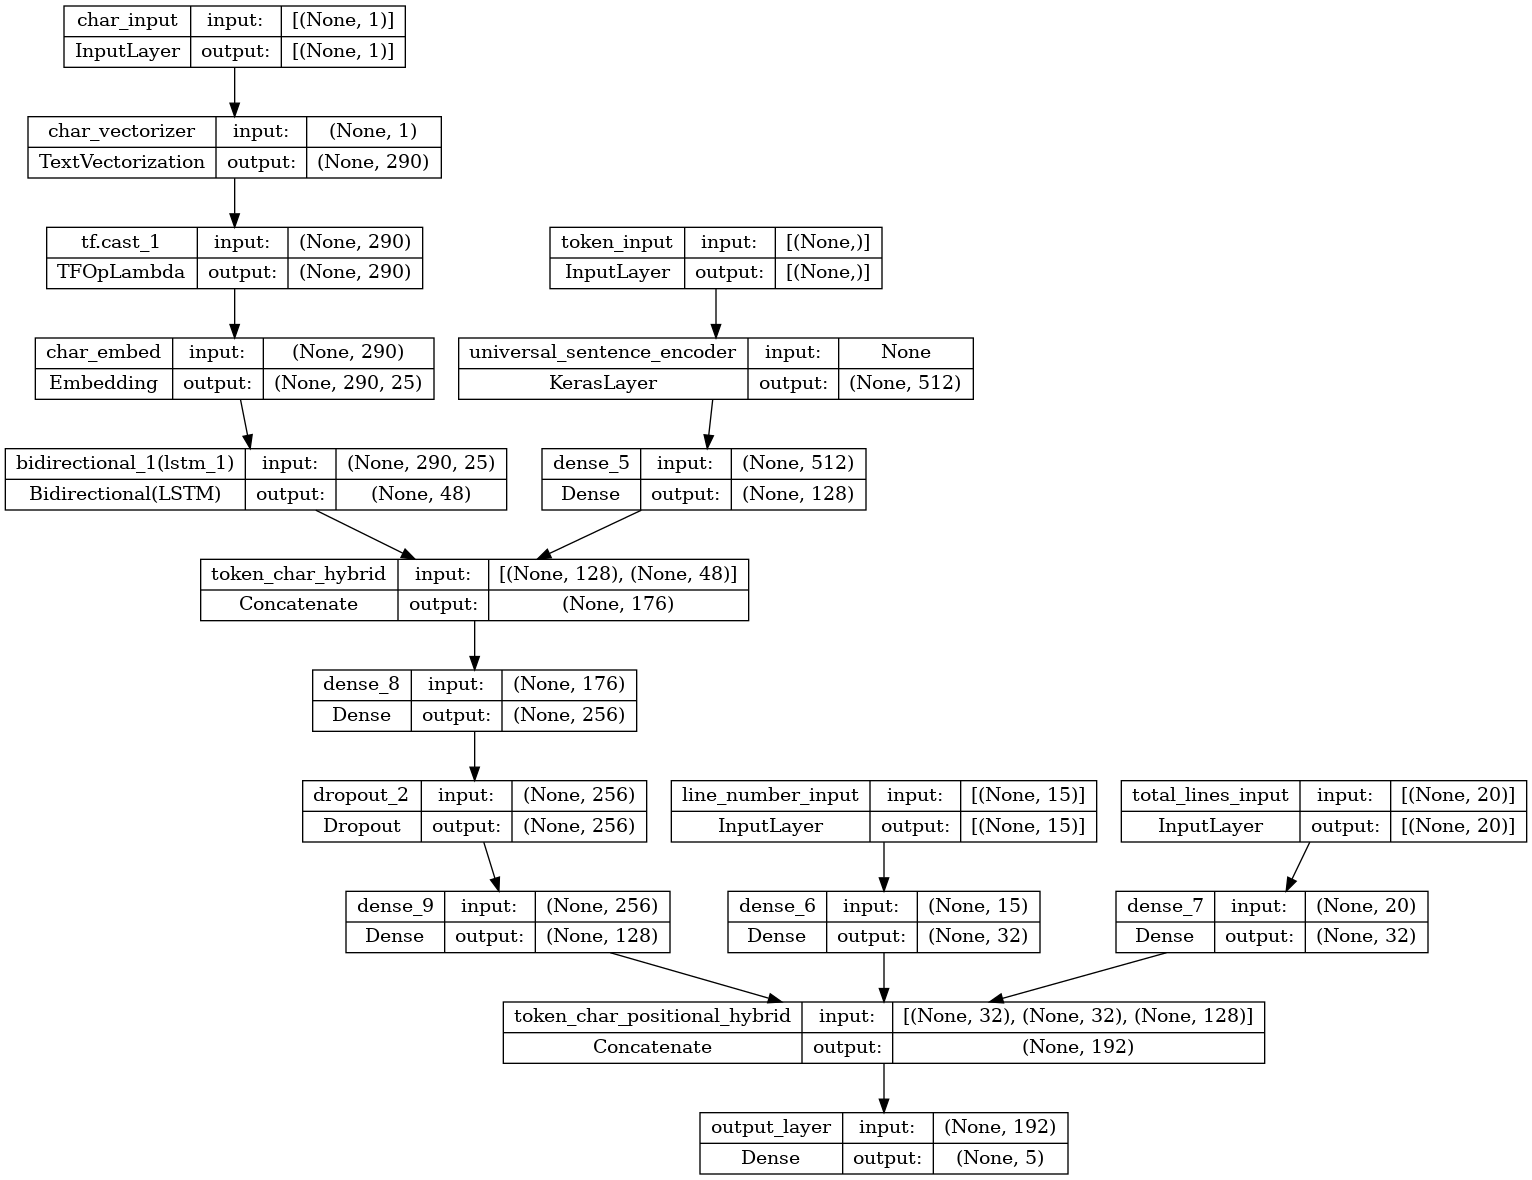

In [88]:
# Plot the model
keras.utils.plot_model(model_5, show_shapes=True, show_layer_names=True)

In [89]:
# Compile the model
model_5.compile(loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.2),  # add label smoothing
                optimizer=keras.optimizers.Adam(),
                metrics=["accuracy"])

What is label smoothing?

For example, if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization:

Label smoothing: `[0.01, 0.01, 0.96, 0.01, 0.01]`

### Create tribrid embedding datasets using tf.data

In [90]:
# Combine token, char, line number and total lines datasets
train_tribrid_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars, train_line_numbers_one_hot, train_total_lines_one_hot))
train_tribrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_tribrid_dataset = tf.data.Dataset.zip((train_tribrid_data, train_tribrid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

val_tribrid_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars, val_line_numbers_one_hot, val_total_lines_one_hot))
val_tribrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_tribrid_dataset = tf.data.Dataset.zip((val_tribrid_data, val_tribrid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

# Check out the training tribrid dataset
train_tribrid_dataset, val_tribrid_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predictions whit our tribrid model

In [91]:
# Fit the model on tokens, chars, line numbers and total lines
model_5_history = model_5.fit(train_tribrid_dataset,
                              steps_per_epoch=int(0.1 * len(train_tribrid_dataset)),
                              epochs=3,
                              validation_data=val_tribrid_dataset,
                              validation_steps=int(0.1 * len(val_tribrid_dataset)))

Epoch 1/3
562/562 [==============================] - 68s 108ms/step - loss: 1.0971 - accuracy: 0.7223 - val_loss: 0.9782 - val_accuracy: 0.8098
Epoch 2/3
562/562 [==============================] - 58s 103ms/step - loss: 0.9644 - accuracy: 0.8127 - val_loss: 0.9479 - val_accuracy: 0.8238
Epoch 3/3
562/562 [==============================] - 53s 94ms/step - loss: 0.9488 - accuracy: 0.8207 - val_loss: 0.9358 - val_accuracy: 0.8241


In [92]:
# Evaluate the model on the validation dataset
model_5.evaluate(val_tribrid_dataset)

945/945 [==============================] - 47s 50ms/step - loss: 0.9321 - accuracy: 0.8314


[0.9320811033248901, 0.8313915133476257]

In [93]:
# Make predictions with the tribrid model
model_5_pred_probs = model_5.predict(val_tribrid_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)

# Calculate model_5 results
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

945/945 [==============================] - 44s 45ms/step


{'accuracy': 83.13915000661989,
 'precision': 83.16292988008831,
 'recall': 83.13915000661989,
 'f1': 82.94240771127222}

## Compare model results

In [94]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_conv1D": model_1_results,
                                  "model_2_USE_feature_extractor": model_2_results,
                                  "model_3_conv1D_char_embedding": model_3_results,
                                  "model_4_token_and_char_embeddings": model_4_results,
                                  "model_5_tribrid_model": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,71.864670,72.183238,69.892504
model_1_conv1D,78.452271,78.134435,78.452271,78.232208
model_2_USE_feature_extractor,71.256454,71.294922,71.256454,70.978881
model_3_conv1D_char_embedding,65.831458,64.860931,65.831458,64.678452
model_4_token_and_char_embeddings,73.566795,73.629051,73.566795,73.293921
model_5_tribrid_model,83.139150,83.162930,83.139150,82.942408


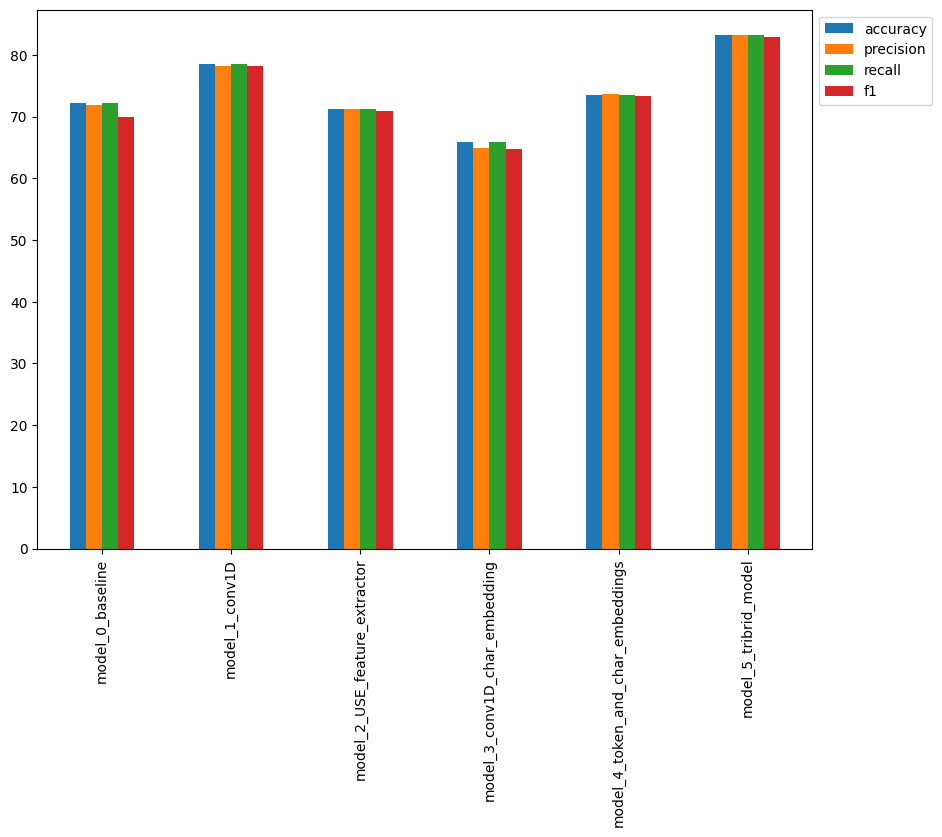

In [95]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

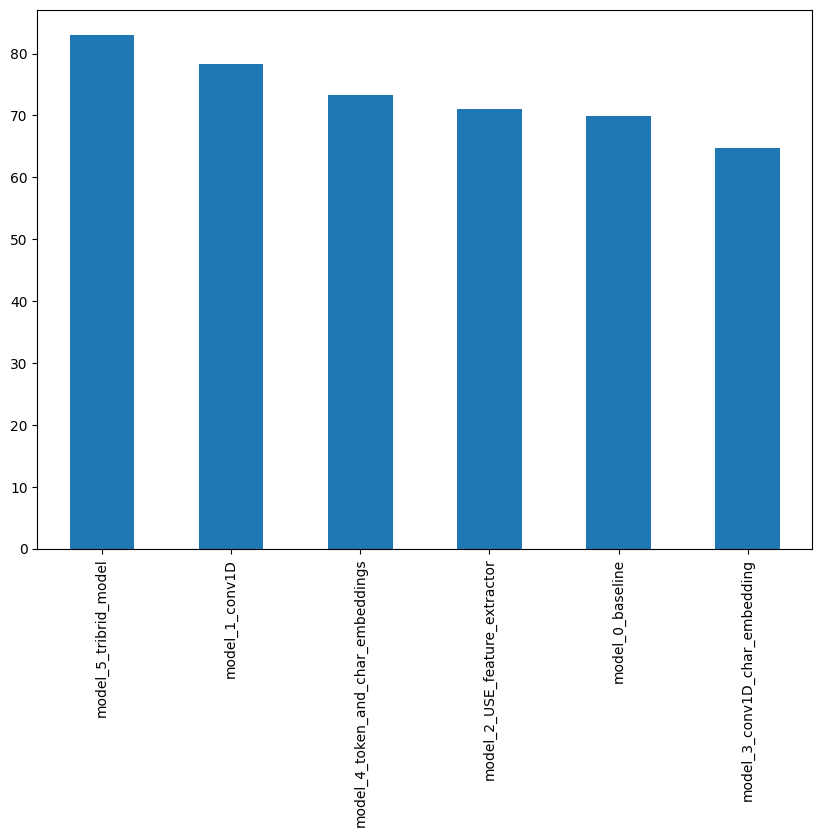

In [96]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

# Exercises
https://github.com/mrdbourke/tensorflow-deep-learning#-09-milestone-project-2-skimlit--exercises

## Model 6
Mixed model 1 and model 5 to evaluate new performance

In [157]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers # type: ignore

In [196]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization # type: ignore

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_sequence_length=output_seq_len)

# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [197]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), 
                               output_dim=128, 
                               mask_zero=True, 
                               name="token_embedding")

In [198]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [201]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    output_mode="int",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

char_vocab = char_vectorizer.get_vocabulary()

# Create a character-level embedding layer
char_embed = keras.layers.Embedding(
    input_dim=len(char_vocab),  
    output_dim=25,  
    mask_zero=True,  
    name="char_embed"
)

In [203]:
print(f"Tipo de datos: {char_vectors.dtype}")
print(f"Forma del tensor: {char_vectors.shape}")

Tipo de datos: int64
Forma del tensor: (None, 290)


In [204]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = token_embed(text_vectorizer(token_inputs))
token_dense = layers.Dense(128, activation="relu")(token_embeddings)
token_pooled = layers.GlobalAveragePooling1D()(token_dense)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_pooled)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# 3. Line number inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs, outputs=y)

# 5. Combine token and char models with line number inputs
combined_embeddings = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)  # add dropout for regularization
z = layers.Dense(128, activation="relu")(z)

# 6. Combine positional embeddings with combined embeddings
tribrid_embeddings = layers.Concatenate(name="token_char_positional_hybrid")([line_number_model.output,
                                                                              total_lines_model.output,
                                                                              z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_6 = tf.keras.Model(inputs=[token_model.input, char_model.input, line_number_model.input, total_lines_model.input],
                         outputs=output_layer,
                         name="model_6_tribrid_model_custom_embed")

# Get a summary of the model
model_6.summary()

AttributeError: Exception encountered when calling layer 'char_embed' (type Embedding).

'str' object has no attribute 'base_dtype'

Call arguments received by layer 'char_embed' (type Embedding):
  • inputs=<KerasTensor shape=(None, 290), dtype=int64, sparse=False, name=keras_tensor_267>

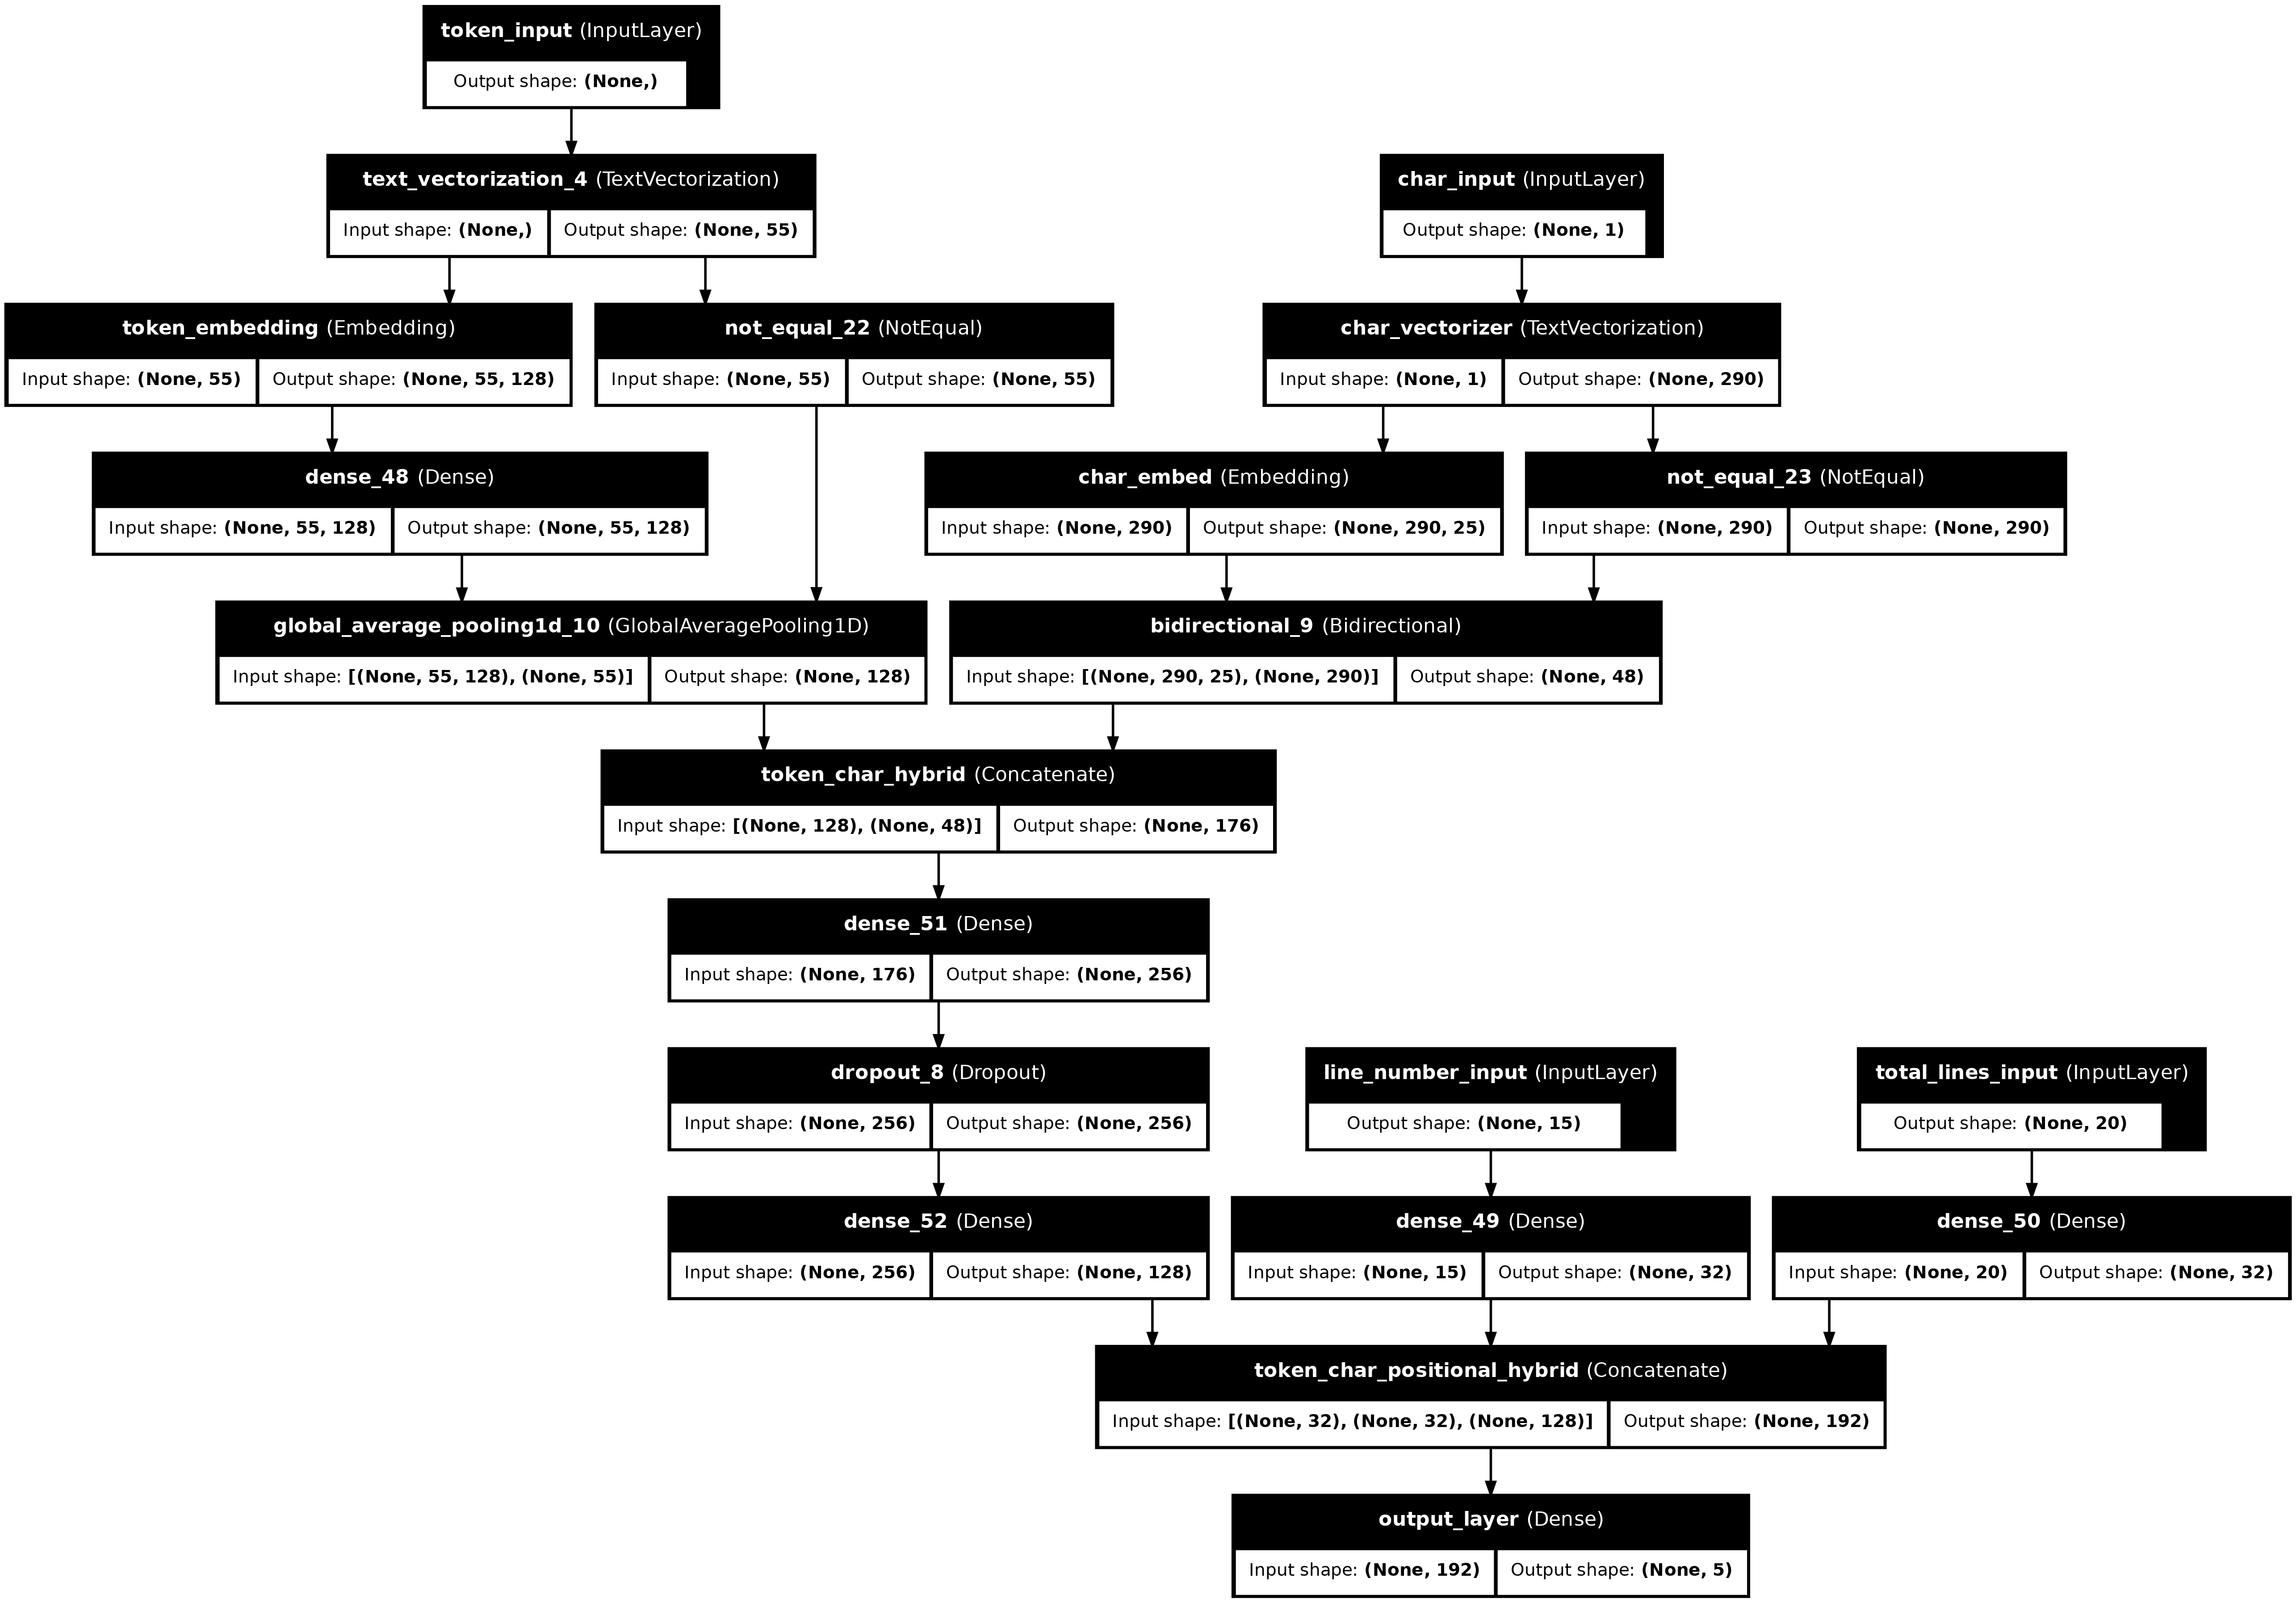

In [ ]:
# Visualize the model
from tensorflow.keras.utils import plot_model # type: ignore
plot_model(model_6, show_shapes=True, show_layer_names=True)

In [ ]:
# Combine token, char, line number and total lines datasets
train_tribrid_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars, train_line_numbers_one_hot, train_total_lines_one_hot))
train_tribrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_tribrid_dataset = tf.data.Dataset.zip((train_tribrid_data, train_tribrid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

val_tribrid_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars, val_line_numbers_one_hot, val_total_lines_one_hot))
val_tribrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_tribrid_dataset = tf.data.Dataset.zip((val_tribrid_data, val_tribrid_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Compile the model
model_6.compile(loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model on tokens, chars, line numbers and total lines
model_6_history = model_6.fit(train_tribrid_dataset,
                              steps_per_epoch=int(0.1 * len(train_tribrid_dataset)),
                              epochs=3,
                              validation_data=val_tribrid_dataset,
                              validation_steps=int(0.1 * len(val_tribrid_dataset)))

Epoch 1/3
144/562 ━━━━━━━━━━━━━━━━━━━━ 25s 60ms/step - accuracy: 0.4264 - loss: 1.4496

2024-08-25 15:54:27.608233: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: assertion failed: [You are passing a RNN mask that does not correspond to right-padded sequences, while using cuDNN, which is not supported. With cuDNN, RNN masks can only be used for right-padding, e.g. `[[True, True, False, False]]` would be a valid mask, but any mask that isn\'t just contiguous `True`\'s on the left and contiguous `False`\'s on the right would be invalid. You can pass `use_cudnn=False` to your RNN layer to stop using cuDNN (this may be slower).]
	 [[{{function_node __inference_one_step_on_data_215407}}{{node model_6_tribrid_model_custom_embed_1/bidirectional_9_1/forward_lstm_9_1/Assert/Assert}}]]


InvalidArgumentError: Graph execution error:

Detected at node model_6_tribrid_model_custom_embed_1/bidirectional_9_1/forward_lstm_9_1/Assert/Assert defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/gus/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/gus/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/gus/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/gus/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/gus/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/gus/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/gus/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/gus/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/home/gus/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/gus/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/home/gus/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/gus/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/gus/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/gus/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/gus/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/gus/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/gus/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_1492/2493044217.py", line 7, in <module>

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/models/functional.py", line 175, in call

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/models/functional.py", line 556, in call

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py", line 218, in call

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/layers/rnn/lstm.py", line 570, in call

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py", line 406, in call

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/layers/rnn/lstm.py", line 537, in inner_loop

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/rnn.py", line 841, in lstm

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/rnn.py", line 874, in _cudnn_lstm

  File "/home/gus/.local/lib/python3.10/site-packages/keras/src/backend/tensorflow/rnn.py", line 557, in _assert_valid_mask

assertion failed: [You are passing a RNN mask that does not correspond to right-padded sequences, while using cuDNN, which is not supported. With cuDNN, RNN masks can only be used for right-padding, e.g. `[[True, True, False, False]]` would be a valid mask, but any mask that isn\'t just contiguous `True`\'s on the left and contiguous `False`\'s on the right would be invalid. You can pass `use_cudnn=False` to your RNN layer to stop using cuDNN (this may be slower).]
	 [[{{node model_6_tribrid_model_custom_embed_1/bidirectional_9_1/forward_lstm_9_1/Assert/Assert}}]] [Op:__inference_one_step_on_iterator_215562]